# Implementation of a Convolutional Neural Network (CNN) classification model with Word2Vec embeddings

Note this notbook downloads the required data from a google drive in which the data acquired from https://github.com/sebischair/Medical-Abstracts-TC-Corpus is installed.

The use of implementation within GoogleColab aso allows the user to utilise a public GPU.

## 0.1 Required packages



In [28]:
import nltk
import pickle
import pandas as pd
import requests
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
import string
from nltk.tokenize import word_tokenize
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data

True

## 0.2 Data installations

This cell requires the user to downloads the dataset mentioned previous to a path they can input below.


In [29]:
#Installation of dataset
from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv') #input own path
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv') # ""

## 0.3 Device agnostic code

If running on google colab reader should set 'runtime type to GPU (graphical processing unit).

The purpose for creation of rendering images means it has faster compute time than using a CPU, as tasks are divided into much smaller parts running on a larger number of cores in parallel.

This is useful in our implementation as training a NN over multiple epochs can take time, and computational speedup is always welcomed.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1 Preprocessing and data preparation

Analysis and derivation found in file '01_Introductin_EDA_and_preprocessing.ipynb'

In [46]:
en_stop = set(stopwords.words('english'))
def preprocess(data):
    data_proc = []
    for doc in data['medical_abstract']:
        #lowercases document
        doc = doc.lower()
        #removes any non-letter characters
        doc = re.sub(r'\b[^a-zA-Z]+\b', ' ', doc)
        #tokenize
        toks = nltk.word_tokenize(doc)
        #remove tokens of lenth <= 1 (can be varied)
        toks = [tok for tok in toks if len(tok) > 1]
        #remove stopwords
        toks = [tok for tok in toks if tok not in en_stop]
        #lemmatize
        toks = [WordNetLemmatizer().lemmatize(tok) for tok in toks]
        data_proc.append(toks)
    return data_proc

In [47]:
text_train = train_dataset['medical_abstract']
y_train = train_dataset['condition_label']
text_test = test_dataset['medical_abstract']
y_test = test_dataset['condition_label']

In [53]:
X_trains  = preprocess(train_dataset)
X_tests = preprocess(test_dataset)
#print(X_trains[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_trains)

X_train = tokenizer.texts_to_sequences(X_trains)
X_test = tokenizer.texts_to_sequences(X_tests)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
#print(X_train[0])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


X_train_tensor = torch.LongTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)



X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)
test_loader = test_loader

## 2 Word2Vec

https://arxiv.org/pdf/1301.3781.pdf [3]

Word2Vec is an embedding that considers similarities of words within texts,and outputs a vectorisation representation for words within a corpus. Similarities within word2vec consider arangements and combinations within sentences and their gramatic relationship, as well as semantic similarity, that considers context based on meaning.

It is a useful technique because it allows personalisation for the user in how closely you want the relationship between words to be considered (tailored via `window`), so can be altered in context. It also is useful in the context of neural networks as the vectorisation output is easy to use as an input in the appropriate model.





### 2.1 Implementation

The cell below trains a word2vec model based on the corpus of texts provided in the training data.

In [49]:
import random
torch.manual_seed(302)
np.random.seed(302)
random.seed(302)
# Train the Word2Vec model
vocab_size = len(tokenizer.word_index) + 1
w2v_model = Word2Vec(X_trains, vector_size=100, window=5, min_count=1, workers=4)
print(w2v_model)
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


Word2Vec<vocab=30615, vector_size=100, alpha=0.025>
(30616, 100)


## 3 Evaluation metrics

Used in model evaluation. Note the accuracy function and timeit function are retreived from: mrdbuorke [2]

In [51]:
#Accuracy (source mrdbuorke colab link)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [52]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start adn end time. """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end= end_time, device = "cpu")

Train time on cpu: 0.000 seconds


2.6517000151216052e-05

In [61]:
def performance(conf_mat):
  TP = 0
  for i in range(conf_mat.shape[0]):
    Class = df_labels['condition_name'][i]
    tp = conf_mat[i, i]
    fp = np.sum(conf_mat[:, i]) - tp
    fn = np.sum(conf_mat[i, :]) - tp
    tn = np.sum(conf_mat) - (tp + fp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    TP += tp
    print(Class.upper())
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
  accuracy_tot = TP / np.sum(conf_mat)
  print(f"Total Accuracy: {accuracy_tot:.3f}")
  return

## 4 CNN model

https://arxiv.org/ftp/arxiv/papers/2301/2301.11696.pdf [4]

To capture the complicated structures of sentences and texts within the english language a successful classification model must be able to identify the intricate and varying details within large corpuses of texts. This is where convolutional neural networks have become a leading model in doing said thing, the deep learning and adaptability of CNNs allow for compliacated patterns within the context to be identified, and thus reasons why word2vec and CNNs usually go hand-in-hand.

Our implementation of the convoluation neural network to classify the medical abstracts is derived from the implementation within this report https://arxiv.org/ftp/arxiv/papers/1704/1704.06841.pdf [5], where we use the 2 convoluational and maxpool layers as specified, however running our own parameter tuning for learning rate and kernels through anaylsing accuracy scores.

While the model's parameters and layers aren't thoroughly analysed in the `appendix.ipynb` file,sufficient support on structure from the report and adaption of specific parameters allows us to conclude a "sufficient neural network" structure for classification as implemented below.



### 4.1 Model Architecture

In [54]:
num_classes =5
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)
#create vector of labels 0,4

class CNNMulticlass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length):
        super(CNNMulticlass, self).__init__()
        #Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #keeps original embedding matrix

        #two convolutional layers and 2 max pool layers like paper[1]
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=2)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=2)
        self.pool2 = nn.MaxPool1d(5)
        #flattening for fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * ((max_length - 4) // 25) , 256)
        self.fc2 = nn.Linear(256, num_classes)
        #softmax activation for final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      #pass input through embedding layer
        x = self.embedding(x)
        #need to rearrange for conv layer
        x = x.permute(0, 2, 1)
        #RelU activations with conv and max pool layers
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x




### 4.2 Model instantiation, training and testing

In [59]:
model_multiclass = CNNMulticlass(vocab_size, 100, embedding_matrix, max_length).to(device)
optimizer = torch.optim.Adam(model_multiclass.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


from tqdm.auto import tqdm
print(len(test_loader))
train_time_start_on_cpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    train_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        model_multiclass.train()
        # Forward pass'=
        #print(inputs)
        y_pred = model_multiclass(inputs).to(device)
        #print(y_pred.softmax(dim=1))
        #Calculate loss
        labels = labels.long() -1
        #print(labels)
        loss = criterion(y_pred, labels)
        train_loss += loss
        #optimizer zero-grad
        optimizer.zero_grad()
        #loss backward
        loss.backward()
        #step
        optimizer.step()

    train_loss /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_multiclass.eval()
    with torch.inference_mode():
        for X_test_tensor, y_test_tensor in test_loader:
            #forward pass
            test_pred = model_multiclass(X_test_tensor).to(device)
            #print(y_test_tensor -1)[0,4]
            #calculate loss
            y_test_tensor = y_test_tensor-1 #.Long()
            y_test_tensor = y_test_tensor.to(device)
            test_loss += criterion(test_pred, y_test_tensor)
            #calculate accuracy
            y_preds = test_pred.argmax(dim=1)
            #print(y_preds)
            test_acc += accuracy_fn(y_true = y_test_tensor, y_pred = y_preds)
        # Calculate the test loss average per batch
        test_loss /= len(test_loader)

        # Calculate the test acc average per batch
        test_acc /= len(test_loader)



    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    train_time_end_on_cpu = timer()
    total_train_time_model_multiclass = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device=str(next(model_multiclass.parameters()).device))

91


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
-----

Train loss: 1.2149 | Test loss: 1.1682, Test acc: 50.6868
Train time on cuda:0: 1.549 seconds
Epoch:1
-----

Train loss: 1.0955 | Test loss: 1.0909, Test acc: 50.9959
Train time on cuda:0: 2.585 seconds
Epoch:2
-----

Train loss: 1.0607 | Test loss: 1.0848, Test acc: 53.9835
Train time on cuda:0: 3.581 seconds
Epoch:3
-----

Train loss: 1.0428 | Test loss: 1.0541, Test acc: 55.6319
Train time on cuda:0: 4.835 seconds
Epoch:4
-----

Train loss: 1.0283 | Test loss: 1.0547, Test acc: 56.8681
Train time on cuda:0: 6.116 seconds
Epoch:5
-----

Train loss: 1.0280 | Test loss: 1.0407, Test acc: 56.5247
Train time on cuda:0: 7.398 seconds
Epoch:6
-----

Train loss: 1.0091 | Test loss: 1.0507, Test acc: 55.8379
Train time on cuda:0: 8.637 seconds
Epoch:7
-----

Train loss: 1.0040 | Test loss: 1.0501, Test acc: 56.0096
Train time on cuda:0: 9.649 seconds
Epoch:8
-----

Train loss: 0.9990 | Test loss: 1.0475, Test acc: 56.3530
Train time on cuda:0: 10.648 seconds
Epoch:9
-----

Tra

## 4.3 Model Evaluation

Making predictions...:   0%|          | 0/91 [00:00<?, ?it/s]

mlxtend version: 0.23.0
tensor([2, 4, 4,  ..., 3, 0, 3])
tensor([2, 1, 0,  ..., 3, 1, 2])


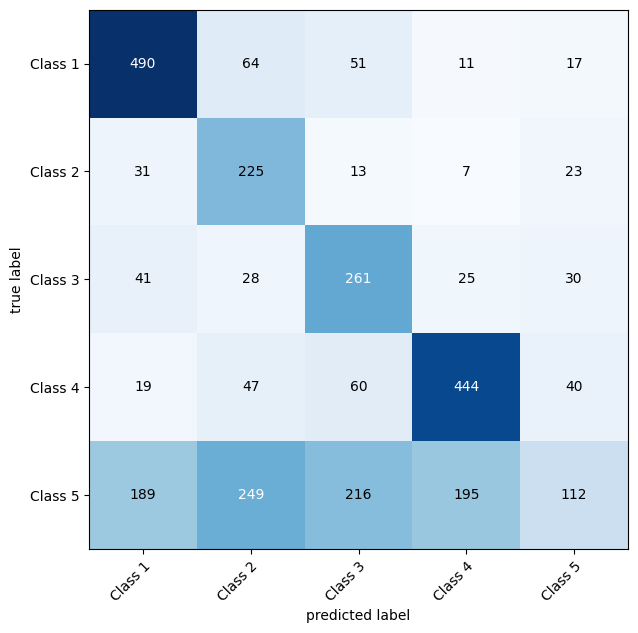

In [69]:
# Import tqdm.auto for progress bar tracking
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

from tqdm.auto import tqdm

#1. Make predictions with trained model
y_preds = []
model_multiclass.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions..."):
    # Send the data and targets to target device
    # DO the forward pass
    X, y = X.to(device), y.to(device)

    y_logits = model_multiclass(X)
    #Turn prediction from logits -> prediction porbabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim =0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

  #COncatenate list of predictions into a tensor
  #print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f" mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
class_names = [f"Class {i}" for i in range(1, 6)]


confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=5)

y_test_tensor = torch.LongTensor(y_test)-1
print(y_test_tensor)
print(y_pred_tensor)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test_tensor)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), #matplotlib likes working with numpy
    figsize=(10,7),
    class_names=class_names,
)


In [70]:
# Run Geraint's code here

Talk about results:
* Strong diagonal line
* Weak classifcation for class 5

## 5 Exploration of misslclassification for class 5

* talk about initial imbalances, reference EDA notebook
* talk about 'General' classification


### 5.1 T-SNE plots for visualisation

* https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d



   condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...
    condition_label                                   medical_abstract
0                 5  Tissue changes around loose prostheses. A cani...
8                 5  Color Doppler diagnosis of mechanical prosthet...
9                 5  Noninvasive diagnosis of right-sided extracard...
12                5  Closure of a bronchopleural fistula with bronc...
18                5  In vitro and in vivo effects within the corona...
(20806, 100)


(15382, 100)


(10439, 100)
(12638, 100)


(13259, 100)


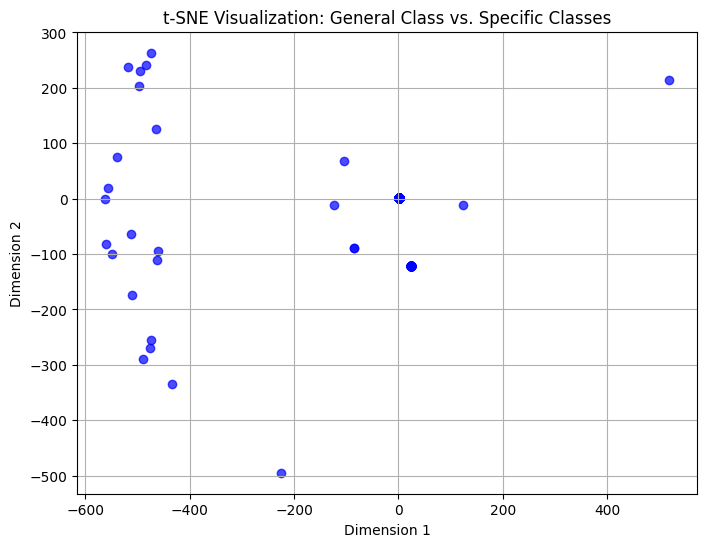

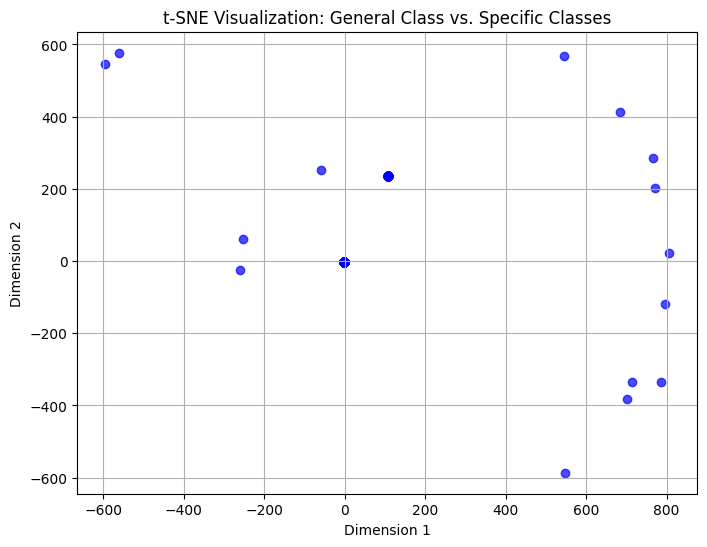

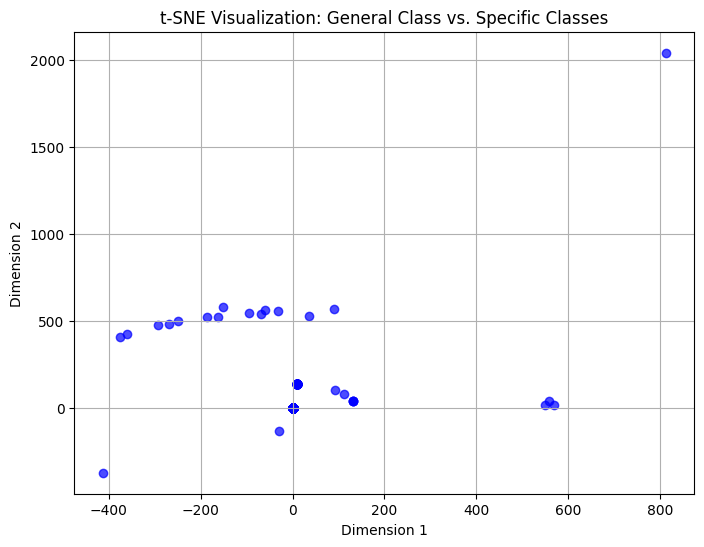

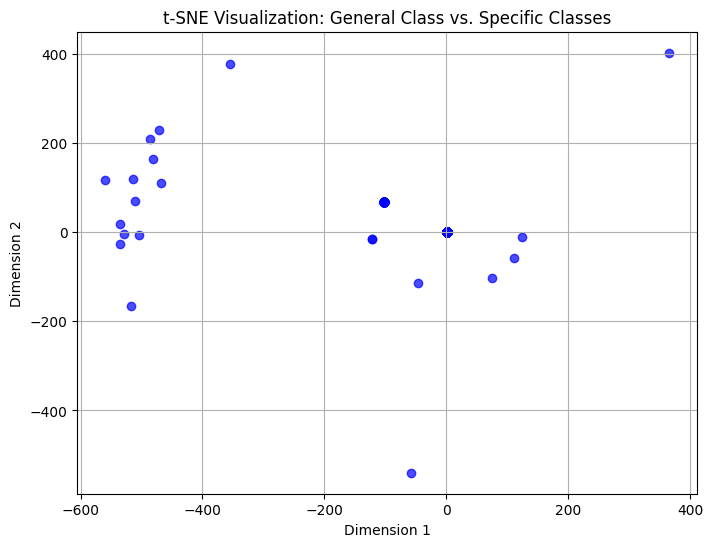

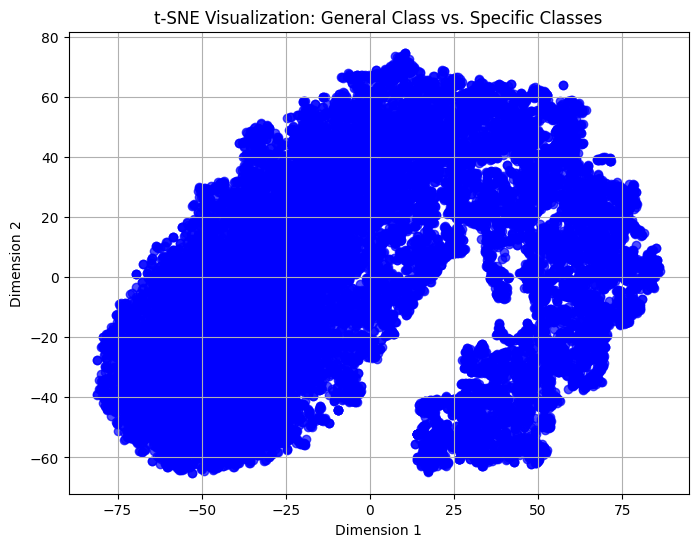

In [75]:
# Split dataset into classes and specific classes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv')


print(train_dataset.head())

neoplasms= train_dataset[train_dataset['condition_label'] == 1]
digestive_system = train_dataset[train_dataset['condition_label'] == 2]
nervous_system = train_dataset[train_dataset['condition_label'] == 3]
cardiovascular = train_dataset[train_dataset['condition_label'] == 4]
general = train_dataset[train_dataset['condition_label'] == 5]

print(general.head())
# Assuming you have lists of texts for the general class and specific classes
neoplasms_texts = neoplasms['medical_abstract']
digestive_texts = digestive_system['medical_abstract']
nervous_texts = nervous_system['medical_abstract']
cardiovascular_texts = cardiovascular['medical_abstract']
general_texts = general['medical_abstract']

neoplasms_train = preprocess(neoplasms)
digestive_train = preprocess(digestive_system)
nervous_train = preprocess(nervous_system)
cardiovascular_train = preprocess(cardiovascular)
general_train = preprocess(general)


# For general class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(general_train)
general_train1 = tokenizer.texts_to_sequences(general_train)
vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
general_train1 = pad_sequences(general_train1, maxlen=max_length, padding='post')
general_w2v_model = Word2Vec(general_train, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embeddings for general and specific classes
general_embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in general_w2v_model.wv:
        general_embedding_matrix[i] = general_w2v_model.wv[word]
print(general_embedding_matrix.shape)
# Replace these steps with your Word2Vec model training process


## FOr neoplasm clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(neoplasms_train)
neoplasms_train1 = tokenizer.texts_to_sequences(neoplasms_train)
neoplasms_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
neoplasms_train1 = pad_sequences(neoplasms_train1, maxlen=max_length, padding='post')
neoplasms_w2v_model = Word2Vec(sentences=neoplasms_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
neoplasms_embedding_matrix = np.zeros((neoplasms_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in neoplasms_w2v_model.wv:
        neoplasms_embedding_matrix[i] = neoplasms_w2v_model.wv[word]
print(neoplasms_embedding_matrix.shape)


## FOr digestive clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(digestive_train)
digestive_train1 = tokenizer.texts_to_sequences(digestive_train)
digestive_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
digestive_train1 = pad_sequences(digestive_train1, maxlen=max_length, padding='post')
digestive_w2v_model = Word2Vec(sentences=digestive_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
digestive_embedding_matrix = np.zeros((digestive_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in digestive_w2v_model.wv:
        digestive_embedding_matrix[i] = digestive_w2v_model.wv[word]
print(digestive_embedding_matrix.shape)


## For nervous system clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(nervous_train)
nervous_train1 = tokenizer.texts_to_sequences(nervous_train)
nervous_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
nervous_train1 = pad_sequences(nervous_train1, maxlen=max_length, padding='post')
nervous_w2v_model = Word2Vec(sentences=nervous_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
nervous_embedding_matrix = np.zeros((nervous_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in nervous_w2v_model.wv:
        nervous_embedding_matrix[i] = nervous_w2v_model.wv[word]
print(nervous_embedding_matrix.shape)


## For cardiovascular clases
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cardiovascular_train)
cardiovascular_train1 = tokenizer.texts_to_sequences(cardiovascular_train)
cardiovascular_vocab_size = len(tokenizer.word_index) + 1
# Pad the sequences to a fixed length
max_length = 100
cardiovascular_train1 = pad_sequences(cardiovascular_train1, maxlen=max_length, padding='post')
cardiovascular_w2v_model = Word2Vec(sentences=cardiovascular_texts, vector_size=100, window=5, min_count=1, workers=4)
# Generate word embes=dding matrix for  specific classes
cardiovascular_embedding_matrix = np.zeros((cardiovascular_vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in cardiovascular_w2v_model.wv:
        cardiovascular_embedding_matrix[i] = cardiovascular_w2v_model.wv[word]
print(cardiovascular_embedding_matrix.shape)



# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_neoplasms = tsne.fit_transform(neoplasms_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_digestive = tsne.fit_transform(digestive_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_nervous = tsne.fit_transform(nervous_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_cardiovascular = tsne.fit_transform(cardiovascular_embedding_matrix)

tsne = TSNE(n_components=2, random_state=42)
embeddings_general = tsne.fit_transform(general_embedding_matrix)


# Plotting
plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_neoplasms):
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for neoplasms class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_digestive):
    label = 'digestive'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for digestive system class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_nervous):
    label = 'neoplasms'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for nervous system class embeddings')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_cardiovascular):
    label = 'cardiovascular'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for cardiovascular system class embeddingss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(embeddings_general):
    label = 'neoplasms'
    color = 'blue'  # Assign different colors to general and specific classes
    plt.scatter(x, y, color=color, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization for general class embeddingss')
plt.grid(True)
plt.show()

From the graphs executed above, it is clear to see a large variance/spread in distribution of the word embeddings in the general pathological category of our data. Thus providing potential justification of the innaccuracies derived from classifying/involving the 'general' class within reasearch.

### Analysis without the 'general pathological conditions' class

From research perfromed within our EDA, classification and t-SNE plot of the embeddings, it is clear to see that including the general pathological conditions category results in inaccuries within our classification as explored within class imbalance and lack of specifcity within the class. Thus furhter analysis in this section is done without the use of the generic class, to explore model accuracy without the anomolous class.

In [77]:
train_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_train.csv') #input own path
test_dataset = pd.read_csv('/content/drive/MyDrive/medical_tc_test.csv') # ""

train_dataset2 = train_dataset[train_dataset['condition_label'] != 5]
test_dataset2 = test_dataset[test_dataset['condition_label'] != 5]

In [83]:
text_train = train_dataset2['medical_abstract']
y_train = train_dataset2['condition_label']
text_test = test_dataset2['medical_abstract']
y_test = test_dataset2['condition_label']

1    1
2    2
3    1
4    3
5    3
Name: condition_label, dtype: int64


In [84]:
X_trains  = preprocess(train_dataset2)
X_tests = preprocess(test_dataset2)
#print(X_trains[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_trains)

X_train = tokenizer.texts_to_sequences(X_trains)
X_test = tokenizer.texts_to_sequences(X_tests)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
#print(X_train[0])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


X_train_tensor = torch.LongTensor(X_train).to(device)
y_train_array = y_train.to_numpy()
y_train_tensor = torch.LongTensor(y_train_array).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)



X_test_tensor = torch.LongTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)
test_loader = test_loader

In [85]:
import random
torch.manual_seed(302)
np.random.seed(302)
random.seed(302)
# Train the Word2Vec model
vocab_size = len(tokenizer.word_index) + 1
w2v_model = Word2Vec(X_trains, vector_size=100, window=5, min_count=1, workers=4)
print(w2v_model)
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


Word2Vec<vocab=26234, vector_size=100, alpha=0.025>
(26235, 100)


In [86]:
num_classes =4
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

class CNNMulticlass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length):
        super(CNNMulticlass, self).__init__()
        #Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #keeps original embedding matrix

        #two convolutional layers and 2 max pool layers like paper[1]
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=2)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=2)
        self.pool2 = nn.MaxPool1d(5)
        #flattening for fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * ((max_length - 4) // 25) , 256)
        self.fc2 = nn.Linear(256, num_classes)
        #softmax activation for final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      #pass input through embedding layer
        x = self.embedding(x)
        #need to rearrange for conv layer
        x = x.permute(0, 2, 1)
        #RelU activations with conv and max pool layers
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [87]:
model_multiclass = CNNMulticlass(vocab_size, 100, embedding_matrix, max_length).to(device)
optimizer = torch.optim.Adam(model_multiclass.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


from tqdm.auto import tqdm
print(len(test_loader))
train_time_start_on_cpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    train_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        model_multiclass.train()
        # Forward pass'=
        #print(inputs)
        y_pred = model_multiclass(inputs).to(device)
        #print(y_pred.softmax(dim=1))
        #Calculate loss
        labels = labels.long() -1
        #print(labels)
        loss = criterion(y_pred, labels)
        train_loss += loss
        #optimizer zero-grad
        optimizer.zero_grad()
        #loss backward
        loss.backward()
        #step
        optimizer.step()

    train_loss /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_multiclass.eval()
    with torch.inference_mode():
        for X_test_tensor, y_test_tensor in test_loader:
            #forward pass
            test_pred = model_multiclass(X_test_tensor).to(device)
            #print(y_test_tensor -1)[0,4]
            #calculate loss
            y_test_tensor = y_test_tensor-1 #.Long()
            y_test_tensor = y_test_tensor.to(device)
            test_loss += criterion(test_pred, y_test_tensor)
            #calculate accuracy
            y_preds = test_pred.argmax(dim=1)
            #print(y_preds)
            test_acc += accuracy_fn(y_true = y_test_tensor, y_pred = y_preds)
        # Calculate the test loss average per batch
        test_loss /= len(test_loader)

        # Calculate the test acc average per batch
        test_acc /= len(test_loader)



    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    train_time_end_on_cpu = timer()
    total_train_time_model_multiclass = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device=str(next(model_multiclass.parameters()).device))

61


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
-----

Train loss: 0.9676 | Test loss: 0.7849, Test acc: 72.7093
Train time on cuda:0: 0.744 seconds
Epoch:1
-----

Train loss: 0.7366 | Test loss: 0.7646, Test acc: 74.6268
Train time on cuda:0: 1.446 seconds
Epoch:2
-----

Train loss: 0.6874 | Test loss: 0.7439, Test acc: 75.1171
Train time on cuda:0: 2.146 seconds
Epoch:3
-----

Train loss: 0.6669 | Test loss: 0.6949, Test acc: 75.4245
Train time on cuda:0: 2.840 seconds
Epoch:4
-----

Train loss: 0.6519 | Test loss: 0.7042, Test acc: 74.6048
Train time on cuda:0: 3.537 seconds
Epoch:5
-----

Train loss: 0.6445 | Test loss: 0.6842, Test acc: 75.9148
Train time on cuda:0: 4.233 seconds
Epoch:6
-----

Train loss: 0.6274 | Test loss: 0.6503, Test acc: 77.3492
Train time on cuda:0: 4.921 seconds
Epoch:7
-----

Train loss: 0.6236 | Test loss: 0.6753, Test acc: 77.0126
Train time on cuda:0: 5.794 seconds
Epoch:8
-----

Train loss: 0.6341 | Test loss: 0.6680, Test acc: 76.3978
Train time on cuda:0: 6.684 seconds
Epoch:9
-----

Trai

Making predictions...:   0%|          | 0/61 [00:00<?, ?it/s]

mlxtend version: 0.23.0
tensor([2, 0, 3,  ..., 3, 0, 3])
tensor([2, 0, 2,  ..., 0, 0, 2])


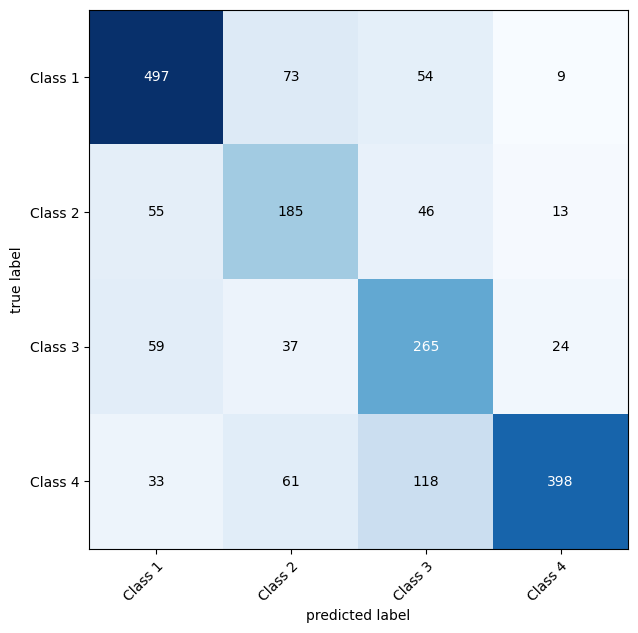

In [88]:
# Import tqdm.auto for progress bar tracking
random.seed(302)
torch.cuda.manual_seed(302)
torch.manual_seed(302)

from tqdm.auto import tqdm

#1. Make predictions with trained model
y_preds = []
model_multiclass.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions..."):
    # Send the data and targets to target device
    # DO the forward pass
    X, y = X.to(device), y.to(device)

    y_logits = model_multiclass(X)
    #Turn prediction from logits -> prediction porbabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim =0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

  #COncatenate list of predictions into a tensor
  #print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f" mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
class_names = [f"Class {i}" for i in range(1, 5)]


confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=4)

y_test_tensor = torch.LongTensor(y_test)-1
print(y_test_tensor)
print(y_pred_tensor)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test_tensor)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), #matplotlib likes working with numpy
    figsize=(10,7),
    class_names=class_names,
)

Overall we can see that accuracy does improve with the exclusion of the general class.